# Proyecto 03
## Visión Por Computadora

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [102]:
images_dir = 'imagenes/'
input_dir = 'input0'

(-0.5, 570.5, 305.5, -0.5)

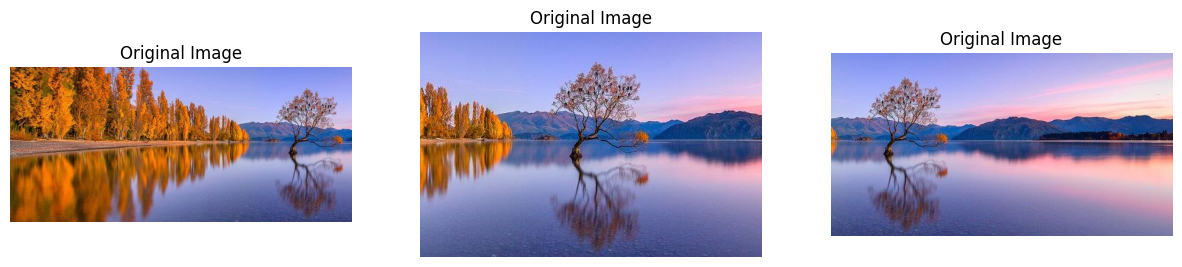

In [103]:

# Create a 1x3 subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
image_1 = cv2.imread(os.path.join(images_dir, input_dir, 'i1.jpeg'))
ax[0].imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')

image_2 = cv2.imread(os.path.join(images_dir, input_dir, 'i2.jpeg'))
ax[1].imshow(cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB))
ax[1].set_title('Original Image')
ax[1].axis('off')

image_3 = cv2.imread(os.path.join(images_dir, input_dir, 'i3.jpeg'))
ax[2].imshow(cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB))
ax[2].set_title('Original Image')
ax[2].axis('off')



In [104]:
# Print height for the images
print('Image 0 height:', image_2.shape[0])
print('Image 1 height:', image_3.shape[0])
print('Image 2 height:', image_1.shape[0])


Image 0 height: 306
Image 1 height: 306
Image 2 height: 306


### 2

In [105]:
image_0_rgb = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_1_rgb = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)
image_2_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

In [106]:
sift = cv2.SIFT_create()
keypoints_0, descriptors_0 = sift.detectAndCompute(image_2, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(image_3, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_1, None)
image_0_kp = cv2.drawKeypoints(image_0_rgb, keypoints_0, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_1_kp = cv2.drawKeypoints(image_1_rgb, keypoints_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_2_kp = cv2.drawKeypoints(image_2_rgb, keypoints_2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


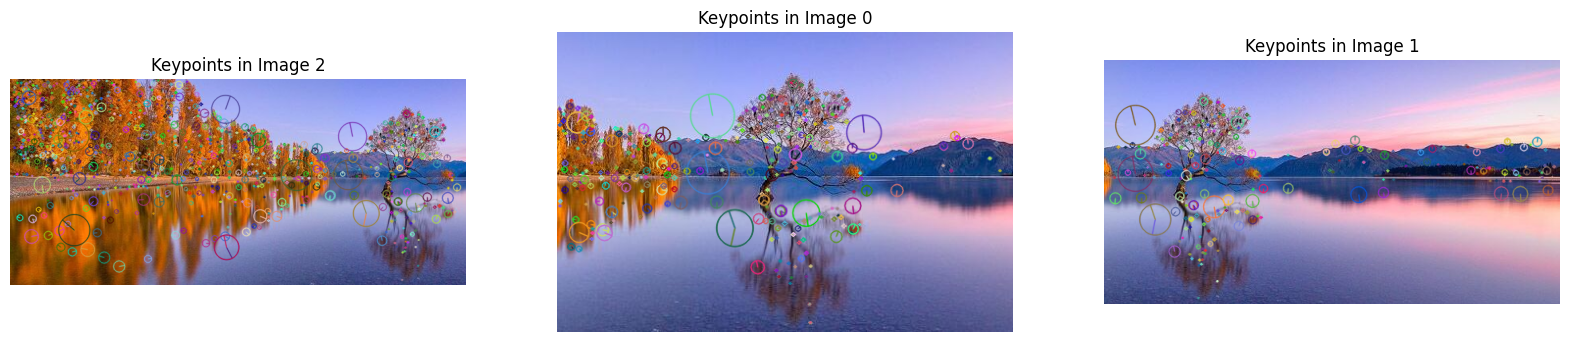

In [107]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_2_kp)
plt.title('Keypoints in Image 2')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_0_kp)
plt.title('Keypoints in Image 0')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_1_kp)
plt.title('Keypoints in Image 1')
plt.axis('off')


plt.show()

In [108]:
def find_homography(image_data_1, image_data_2):
    """
    Find the homography matrix for a pair of images using SIFT, FLANN, and RANSAC.
    """
    
    sift = cv2.SIFT_create()
    
    # Find the keypoints and descriptors with SIFT
    keypoints_1, descriptors_1 = sift.detectAndCompute(image_data_1, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(image_data_2, None)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors_1, descriptors_2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    
    MIN_MATCH_COUNT = 10
    
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        return M, keypoints_1, keypoints_2, good_matches, mask.ravel().tolist()
    else:
        print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
        return None, None, None, None, None

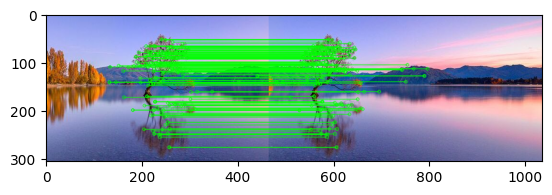

(<matplotlib.image.AxesImage at 0x176f05a90>, None)

In [109]:
H, kp1, kp2, good_matches, mask = find_homography(image_2, image_3)
matchesMask = mask
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(image_0_rgb, kp1, image_1_rgb, kp2, good_matches, None, **draw_params)
plt.imshow(img3, 'gray'),plt.show()

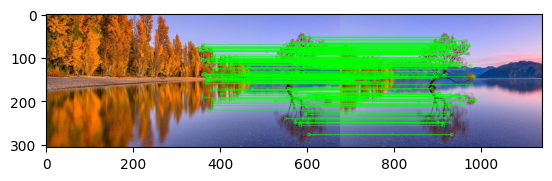

(<matplotlib.image.AxesImage at 0x28af98b10>, None)

In [110]:
# Now between image0 and image2
H, kp1, kp2, good_matches, mask = find_homography(image_1, image_2)
matchesMask = mask
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
									 singlePointColor = (255,0,0),
									 matchesMask = matchesMask, # draw only inliers
									 flags = 2)
img3 = cv2.drawMatches(image_2_rgb, kp1, image_0_rgb, kp2, good_matches, None, **draw_params)
plt.imshow(img3, 'gray'),plt.show()


In [111]:
H

array([[ 9.99338538e-01,  8.80093716e-04, -3.47873790e+02],
       [-2.82475778e-04,  1.00024955e+00,  8.66483433e-02],
       [-1.70732720e-06,  3.47874489e-06,  1.00000000e+00]])

In [112]:
homografias = []

In [113]:
H1_2, kp1, kp2, good_matches, mask = find_homography(image_1, image_2)
homografias.append(H1_2)

In [114]:
H, kp1, kp2, good_matches, mask = find_homography(image_2, image_2)
homografias.append(H)

In [115]:
H2_3, kp1, kp2, good_matches, mask = find_homography(image_2, image_3)
homografias.append(H2_3)

In [116]:
homografias

[array([[ 9.99338538e-01,  8.80093716e-04, -3.47873790e+02],
        [-2.82475778e-04,  1.00024955e+00,  8.66483433e-02],
        [-1.70732720e-06,  3.47874489e-06,  1.00000000e+00]]),
 array([[ 1.00000000e+00,  1.40275782e-17,  3.33510265e-13],
        [-1.09183136e-15,  1.00000000e+00,  3.39703808e-13],
        [-8.53338679e-18, -9.20055047e-19,  1.00000000e+00]]),
 array([[ 1.00232673e+00, -1.00035112e-03, -1.16329902e+02],
        [ 5.31738612e-04,  9.99980117e-01, -5.36783761e-02],
        [ 6.32280998e-06, -5.77138470e-06,  1.00000000e+00]])]

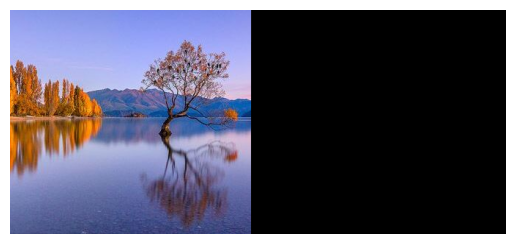

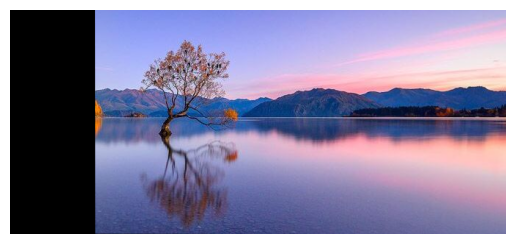

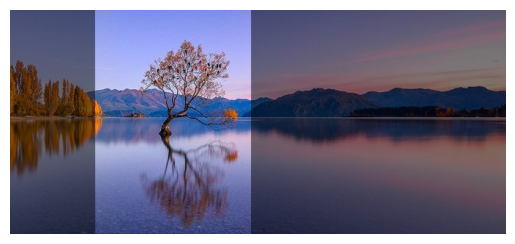

In [117]:
images = [image_1, image_2, image_3]

width = max([x.shape[1] for x in images])
height = max([x.shape[0] for x in images])

warped_img1 = cv2.warpPerspective(image_1, H1_2, (width, height))
warped_img3 = cv2.warpPerspective(image_3, np.linalg.inv(H2_3), (width, height))

plt.figure()
plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(cv2.cvtColor(warped_img3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

final_image = cv2.addWeighted(warped_img1, 0.5, warped_img1, 0.5, 0)
final_image = cv2.addWeighted(final_image, 0.5, warped_img3, 0.5, 0)

plt.figure()
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [118]:
width, height

(677, 306)

In [119]:
final_image.shape

(306, 677, 3)

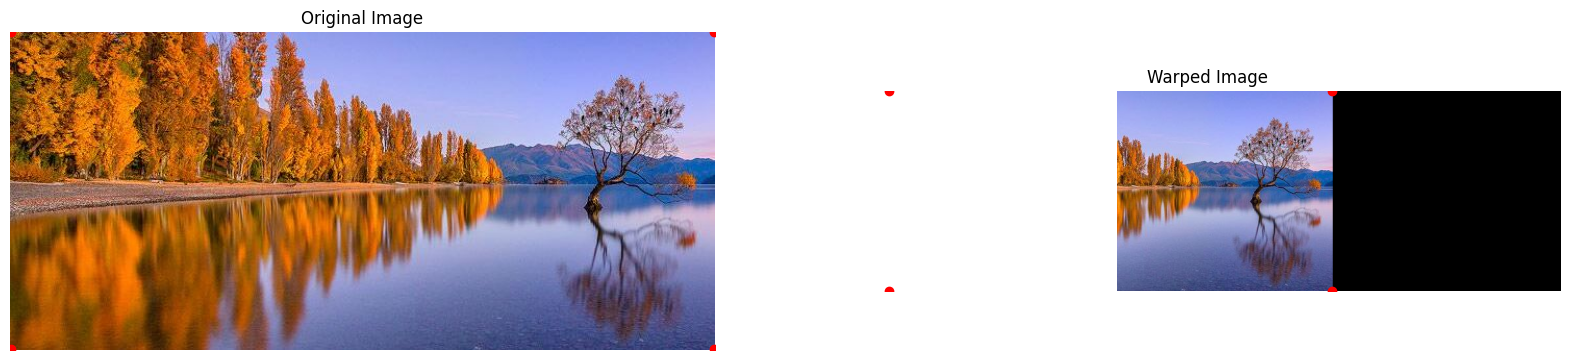

In [120]:
h, w = image_1.shape[:2]
original_corners = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
transformed_corners = cv2.perspectiveTransform(np.array([original_corners]), H1_2)[0]
warped_img1 = cv2.warpPerspective(image_1, H1_2, (w, h))


plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
for x, y in original_corners: plt.plot(x, y, 'ro')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
for x, y in transformed_corners: plt.plot(x, y, 'ro')
plt.axis('off')

plt.show()
